In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_wire.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_wire_time.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_bulk.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_bulk_time.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_gas.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_arc.csv
/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp_FULL_with_test.csv


# **First step - exploratory data analisys**

**Import required libraries**

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
%matplotlib inline
import matplotlib.dates as mpl_dates
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

**General information
Ladle furnace unit (LFU) - metallurgical equipment for out-of-furnace steel processing in the converter shop. The LFU is a large metal ladle with a volume of about 100 tons and is lined from the inside with refractory bricks. Molten steel is poured into the LFU from a steel ladle and then heated by graphite electrodes inserted into the unit's lid.

In addition to electric heating, desulfurization (removal of sulfur from the melt), adjustment of the chemical composition, and sampling are carried out at the CPC. Alloying of metal is carried out both with lumpy ferroalloys through the system to supply bulk materials from bunkers and with wire materials through a tube apparatus. Averaging the chemical composition and temperature is carried out through the bottom purge device in the steel ladle.

After completion of processing at the LFU, the melt is poured back into the steel ladle and either sent to other metal finishing units or to a continuous casting plant, where it solidifies in the form of metallurgical slabs.

Content
Each time the melt enters the Ladle Furnace Unit, the initial temperature and chemical composition are measured. Then, if necessary, the melt is heated for several minutes, after which alloying materials are added, purged with a gas, stirring the melt, and measurements are again carried out following the approved Technological Instruction. This cycle is repeated several times until the target chemistry and melting temperature are reached. In this case, it is not necessary that the melt would be heated in each cycle.

The given datasets provide information on the main technological operations performed at the Ladle Furnace Unit (such as heating, ferroalloy output, chemistry measurement, etc.) with a time reference.

Files
data_gas.csv - the file with supplied gases for purging
data_bulk.csv - the file with the given bulk elements
data_bulk_time.csv - the file with the time of bulk delivery
data_wire.csv - the file with wire supply
data_wire_time.csv - the file with wire recoil time
data_arc.csv - the file with information on the supplied electricity
data_temp.csv - the file with temperature measurements
The latter file is missing part of the temperature measurements.

data_temp_FULL_with_test.csv with the test sample
There is no information about the decoding of the wire and bulk parameters.

The main problem
Temperature forecasting: it is required to build a model that will predict what temperature measurements were at these points in time. First, let's try to build a simple model based on historical data only for temperature.**

**Read the datasets**

In [3]:
temp = pd.read_csv ('/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp.csv')
temp.head (10)

,key,time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [4]:
temp_test = pd.read_csv ('/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp_FULL_with_test.csv')
temp_test.head (10)

,key,time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


**Check the rows with empty values**

In [5]:
temp.isna ().sum ()

key               0
time              0
Temperature    2901
dtype: int64

In [6]:
temp_test.isna ().sum ()

key            0
time           0
Temperature    0
dtype: int64

In [7]:
# drop the missing values
temp = temp.dropna ()
temp.count ()

key            13006
time           13006
Temperature    13006
dtype: int64

**We transform the data into a date series format, since only in this way it will be possible to process the data**

In [8]:
# convert datasets to time series
temp ['time'] = pd.to_datetime(temp['time']) 
temp_test ['time'] = pd.to_datetime(temp_test ['time']) 

In [9]:
temp.describe()  

,key,Temperature
count,13006.000000,13006.000000
mean,1328.447793,1591.840920
std,804.740001,21.375851
min,1.000000,1191.000000
25%,638.000000,1581.000000
50%,1315.000000,1591.000000
75%,1977.750000,1601.000000
max,3241.000000,1705.000000


In [10]:
temp_test.describe()  

,key,Temperature
count,15907.000000,15907.000000
mean,1607.880870,1592.149431
std,942.212073,21.058244
min,1.000000,1189.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


**Create a lag plot for datasets. Lag plots are used to check if a time series is random: random data should not exhibit any structure in the lag plot**

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

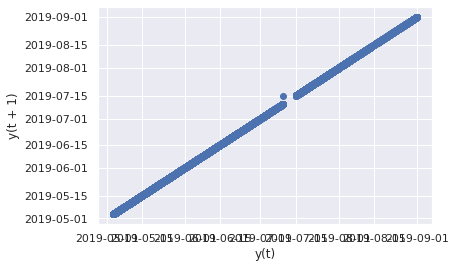

In [11]:
pd.options.display.float_format = "{:, .2f}".format
np.set_printoptions (precision = 2)
warnings.filterwarnings ("ignore")

# import lag_plot function
from pandas.plotting import lag_plot
sns.set ()

# pass the lag argument and plot the values
# when lag = 1 the plot is essentially data [:-1] vs. data [1:]
# plot our temperature data set
lag_plot (temp ['time'])

*As we can see, the data has a clear linear structure.*

**Create an autocorrelation plot for datasets. Autocorrelation plots applied to check randomness in time series by computing autocorrelations for data values at fluctuating time lags. It is heavily used in time series analysis and forecasting. We can calculate the correlation for current time-series observations with observations of previous time steps called lags.**

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

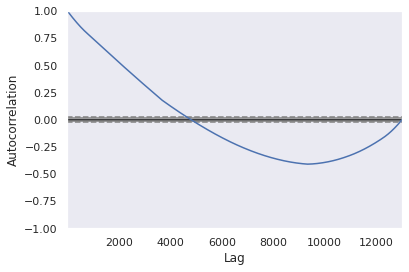

In [12]:
# import autocorrelation plot function
from pandas.plotting import autocorrelation_plot
sns.set ()

# pass the autocorrelation argument and plot the values temperature
temp.reset_index(inplace=True)
temp ['time'] = temp ['time'].apply(mpl_dates.date2num)
temp ['time'] = temp ['time'].astype(float)
autocorrelation_plot (temp ['time'])

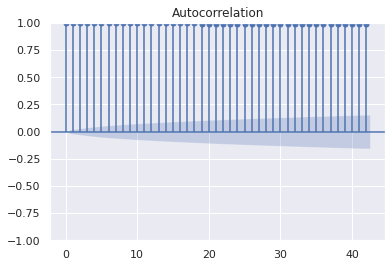

In [13]:
# import plot_acf () function
from statsmodels.graphics.tsaplots import plot_acf

# plot the acf function on the temperature data set
plot_acf (temp ['time'])
plt.show ()

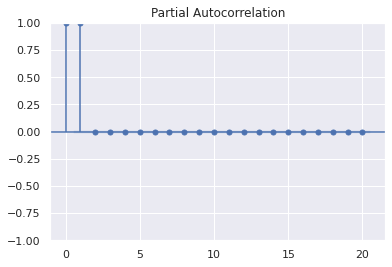

In [14]:
# import plor_pacf () function
from statsmodels.graphics.tsaplots import plot_pacf

# plot the pacf fucntion on the holiday dataset
plot_pacf (temp ['time'], lags = 20)
plt.show ()

**Autoregression modeling. 
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.**

In [15]:
# apply AutoReg model for temperature dataset
modelT = AutoReg (temp ['time'], 1)
resultsT = modelT.fit ()
resultsT.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   time   No. Observations:                13006
Model:                     AutoReg(1)   Log Likelihood               21742.953
Method:               Conditional MLE   S.D. of innovations              0.045
Date:                Fri, 06 Jan 2023   AIC                         -43479.906
Time:                        20:36:11   BIC                         -43457.486
Sample:                             1   HQIC                        -43472.415
                                13006                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9598      0.236     -8.301      0.000      -2.423      -1.497
time.L1        1.0001   1.31e-05   7.65e+04      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9999           +0.0000j            0.9999            0.0000
-----------------------------------------------------------------------------
"""

**Visualize the forecasts**

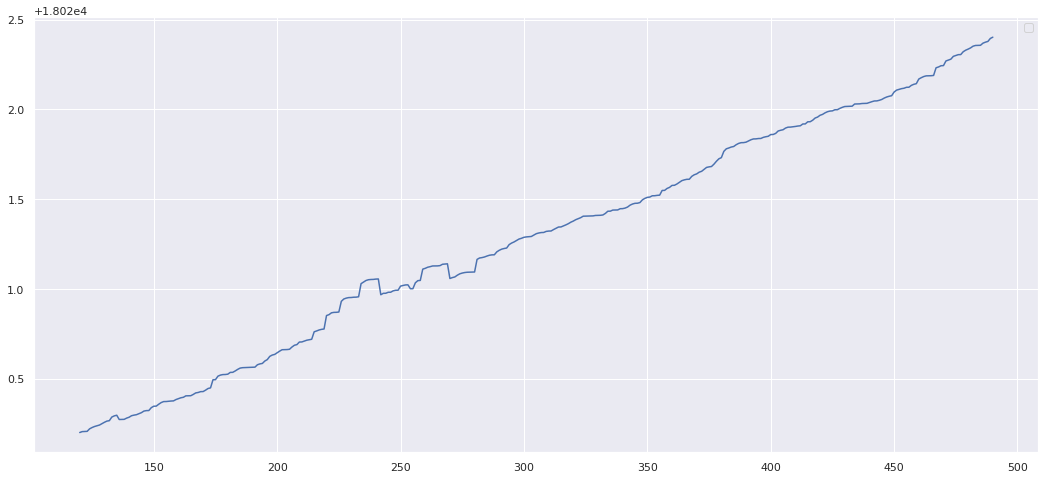

In [16]:
# define figure style, plot package and default figure size
sns.set_style ('darkgrid')
pd.plotting.register_matplotlib_converters ()

# default figure size
sns.mpl.rc ('figure', figsize = (18, 8))

# use plot_predict and visualize forecasts for temperature dataset
figure = resultsT.plot_predict (120, 490)

**Plot_diagnostics indicates that the model captures the key features in the data. They help us determine visually how our model is fitting the data and if any of the basic assumptions of an OLS (ordinary least squares) model are being violated.**

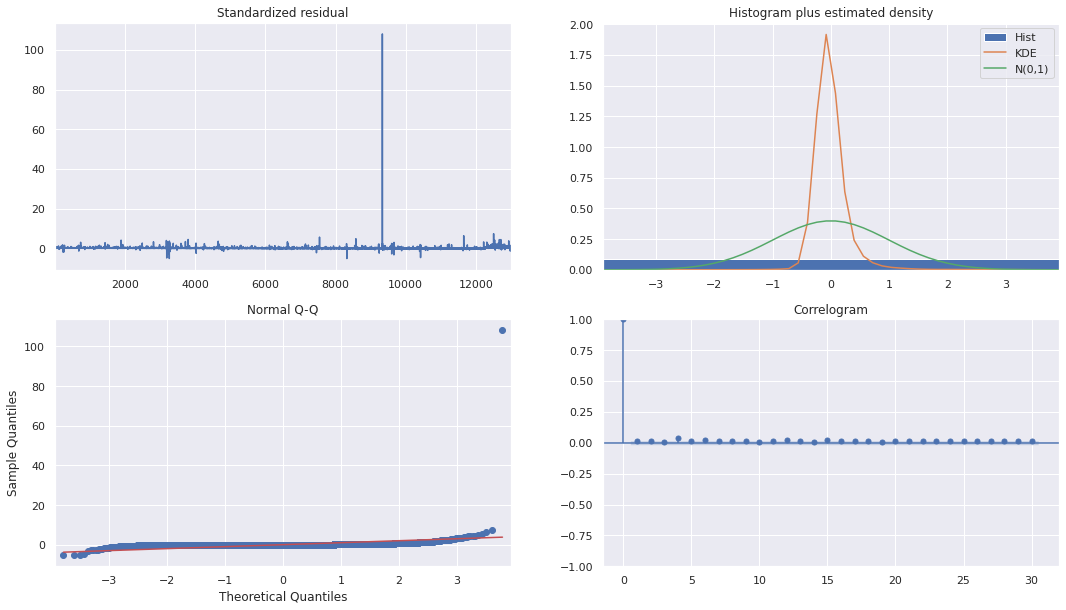

In [17]:
# define default figure size
fig = plt.figure (figsize = (18, 10))

# use plot_predict and visualize forecasts for temperature dataset
fig = resultsT.plot_diagnostics (fig = fig, lags = 30)

**Training the model for temperature dataset**

In [18]:
from sklearn.model_selection import train_test_split
# create train set containing only the model features
X = temp
y = temp_test [1:13007]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print ('Training data shape X: ', X_train.shape)
print ('Test data shape y: ', y_test.shape)

Training data shape X:  (8714, 4)
Test data shape y:  (4292, 3)


In [19]:
# scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler ()
X_train = scaler.fit_transform (X_train)

# scale test data to be in range (0, 1)
X_test = scaler.transform (X_test)

# specify the number of steps to forecast ahead
HORIZON = 3
print ('Forecasting horizon: ', HORIZON, 'days')

Forecasting horizon:  3 days


In [20]:
# make predictions on the test data
training_window = 720

history = [x for x in X_train]
history = history [(-training_window):]
predictions = list ()

for t in range (X_test.shape [0]):
    modelT = AutoReg (temp ['time'], 1)
    modelT_fit = modelT.fit ()
    yhat = modelT_fit.predict
    predictions.append (yhat)
    obs = list (X_test [t])
    # move the trainig window
    history.append (obs [0])
    history.pop (0)
    print (X_test [t])
    print (t+1, ': predicted =', yhat, 'expected =', obs)

[0.51 0.51 0.49 0.77]
1 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7fba3f72d410>> expected = [0.5091503679013898, 0.5089506172839506, 0.48803948884224724, 0.7680311890838207]
[0.73 0.73 0.74 0.73]
2 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7fba3f72d950>> expected = [0.7298283126847368, 0.7283950617283951, 0.7424793032739103, 0.7309941520467835]
[0.62 0.61 0.64 0.75]
3 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7fba3f72ded0>> expected = [0.617193887176907, 0.6135802469135803, 0.6370155440374958, 0.7485380116959064]
[0.25 0.24 0.24 0.83]
4 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7fba4d113550>> expected = [0.2479718256713414, 0.24135802469135803, 0.24019364669078413, 0.8343079922027292]
[0.72 0.72 0.73 0.

**Deep learning for time series forecasting**

In [21]:
# read the data
X = pd.read_csv ('/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp.csv')
y = pd.read_csv ('/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_temp_FULL_with_test.csv')

# sampling the data in X
X = X ['time'].sample(5000)

# sampling the data in y
y = y ['time'].sample (5000)

In [22]:
# setting T - the number of lag variables 
T = 1

# setting the horizon, as we interesting in predicting next day
HORIZON = 1

In [23]:
# convert datasets to time series
X = pd.to_datetime(X) 
y = pd.to_datetime(y)

In [24]:
# create train set containing only the model features
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print ('Training data shape X: ', X_train.shape)
print ('Test data shape X: ', X_test.shape)
print ('Training data shape y: ', y_train.shape)
print ('Test data shape y: ', y_test.shape)

Training data shape X:  (2500,)
Test data shape X:  (2500,)
Training data shape y:  (2500,)
Test data shape y:  (2500,)


In [25]:
# create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.5)

print ('Validation data shape X: ', X_valid.shape)
print ('Validation data shape y: ', y_valid.shape)

Validation data shape X:  (1250,)
Validation data shape y:  (1250,)


In [26]:
# converting data
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
X_valid = np.asarray (X_valid).astype (np.float32)
y_valid = np.asarray (y_valid).astype (np.float32)

In [27]:
# rescale the data to 0-1 scale
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = min_max_scaler.fit_transform(X_train.reshape(-1, 1))
y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1)) 
X_test = min_max_scaler.fit_transform(X_test.reshape(-1, 1))
y_test = min_max_scaler.fit_transform(y_test.reshape(-1, 1))
X_valid = min_max_scaler.fit_transform(X_valid.reshape(-1, 1))
y_valid = min_max_scaler.fit_transform(y_valid.reshape(-1, 1))

In [28]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], T, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], T, y_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], T, X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], T, y_test.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], T, X_valid.shape[1]))
y_valid = np.reshape(y_valid, (y_valid.shape[0], T, y_valid.shape[1]))

**Univariate models**

In [29]:
# number of units in the RNN layer
LATENT_DIM = 5  

# number of samples per mini-batch
BATCH_SIZE = 32

# maximum number of times the training algorithm will cycle through all samples
EPOCHS = 15

# define model and create a Sequential model
model = Sequential ()
model.add (GRU (LATENT_DIM, input_shape = (T, 1)))
model.add (Dense (HORIZON))

model.compile (optimizer = 'RMSprop', loss = 'mse')
model.summary ()

2023-01-06 20:37:17.384005: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [30]:
# specify early stop criteria
GRU_earlystop = EarlyStopping (monitor = 'val_loss', min_delta = 0, patience = 5)

# fit our model
history = model.fit (X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid, y_valid),
                           callbacks = [GRU_earlystop], verbose = 1)

2023-01-06 20:37:17.970604: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
40/40 [==============================] - 4s 20ms/step - loss: 0.1558 - val_loss: 0.1249
Epoch 2/15
40/40 [==============================] - 0s 5ms/step - loss: 0.1186 - val_loss: 0.1076
Epoch 3/15
40/40 [==============================] - 0s 5ms/step - loss: 0.1083 - val_loss: 0.1012
Epoch 4/15
40/40 [==============================] - 0s 5ms/step - loss: 0.1039 - val_loss: 0.0978
Epoch 5/15
40/40 [==============================] - 0s 6ms/step - loss: 0.1001 - val_loss: 0.0942
Epoch 6/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0975 - val_loss: 0.0918
Epoch 7/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0953 - val_loss: 0.0902
Epoch 8/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0937 - val_loss: 0.0898
Epoch 9/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0931 - val_loss: 0.0886
Epoch 10/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0923 - val_loss: 0.0876
Epoch 11/15
40/40 

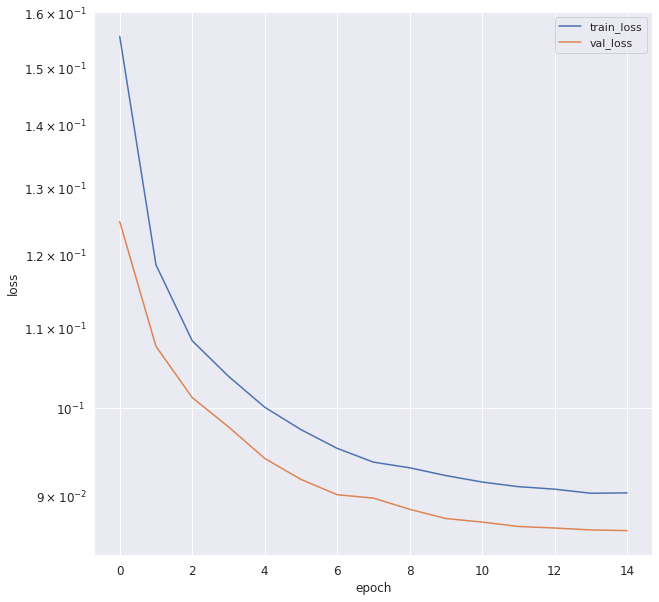

In [31]:
# plot the epochs and train_loss and val_loss
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

*The number of losses decreases with increasing epochs*

In [32]:
# make the predictiondson the X_test and compare those predictions on the y_test
ts_predictions = model.predict (X_test)
ev_ts_data = pd.DataFrame (ts_predictions)
ev_ts_data ['prediction' ]= pd.DataFrame (ts_predictions)
ev_ts_data ['actual'] = np.transpose (y_test).ravel ()

# evaluate our model and compute MAPE (mean absolute percentage error)  
def mape (ts_predictions, actuals):
    return ((ts_predictions - actuals).abs () / actuals).mean ()

mape (ev_ts_data ['prediction'], ev_ts_data ['actual'])

inf

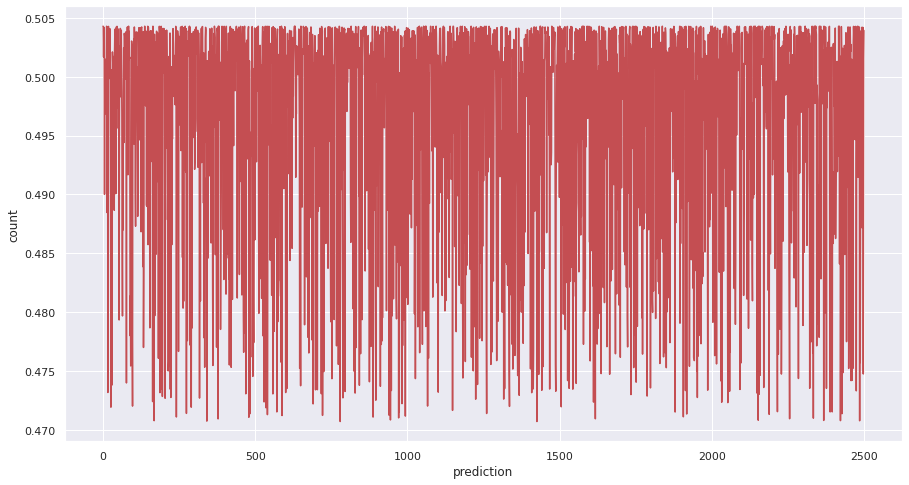

In [33]:
# plot the count of predictions
ev_ts_data ['actual' < '0.3'].plot (x = 'prediction', style = ['r', 'b'], figsize = (15, 8))
plt.xlabel ('prediction', fontsize = 12)
plt.ylabel ('count', fontsize = 12)
plt.show ()

***Let's try another method forTime Series Forecasting using Deep Learning with data_arc dataset (supplied electricity)***

In [34]:
import os
import sys
import math
import shutil
import random
import datetime
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))
print("TensorFlow version: {}".format(tf.__version__))

System version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
TensorFlow version: 2.6.4


In [35]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = False

# Data directories
DATA_DIR = os.path.join("/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_arc.csv")
TRAIN_DIR = os.path.join(DATA_DIR, "/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_arc.csv")
TEST_DIR = os.path.join(DATA_DIR, "/kaggle/input/industrial-data-from-the-ladlefurnace-unit/data_arc.csv")

# Forecasting settings
N_SPLITS = 10
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

# Parameters of the model
SEQ_LEN = 15
DROPOUT_RATE = 0.01
BATCH_SIZE = 64
LEARNING_RATE = 0.015
EPOCHS = 25

# Feature columns
DYNAMIC_FEATURES = ["Heating start", "Heating end", "Active power", "Reactive power"]
STATIC_FEATURES = ["key"]

In [36]:
# Fix random seeds
random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

In [37]:
def create_features(pred_round, train_dir, pred_steps, offset):
    """Create a dataframe of the input features.
    
    Args: 
        pred_round (int): Prediction round (1, 2, ...)
        train_dir (str): Path of the training data directory
        pred_steps (int): Number of prediction steps
        offset (int): Length of training data skipped in retraining

    Returns:
        pd.Dataframe: Dataframe including the input features in original scale
        pd.Dataframe: Dataframe including the normalized features 
        int: Last week of the training data 
    """
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_" + str(pred_round) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    train_df = train_df[["Heating start", "Heating end", "Active power", "Reactive power"]]

    # Create a dataframe to hold all necessary data
    start_list = train_df["Heating start"].unique()
    end_list = train_df["Heating end"].unique()
    train_end_week = train_df["Heating end"].max()
    week_list = range(FIRST_WEEK + offset, train_end_week + GAP + HORIZON)
    d = {"Heating start": heating_list, "Heating end": end_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["Heating start", "Heating end", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "auxi_" + str(pred_round) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["Heating start", "Heating end", "week"])

    # Create relative active power feature
    active_cols = [
        "Active1",
        "Active2",
        "Active3",
        "Active4",
        "Active5",
        "Active6",
        "Active7",
        "Active8",
        "Active9",
        "Active10",
        "Active11",
    ]
    data_filled["Active power"] = data_filled.apply(lambda x: x.loc["Active power" + str(int(x.loc["Reactive power"]))], axis=1)
    data_filled["avg_active"] = data_filled[active_cols].sum(axis=1).apply(lambda x: x / len(active_cols))
    data_filled["active_ratio"] = data_filled["Active power"] / data_filled["avg_active"]
    data_filled.drop(active_cols, axis=1, inplace=True)

    # Fill missing values
    data_filled = data_filled.groupby(["Active power", "Reactive power"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(["Heating start", "Heating end", "week"])
    data_scaled, min_max_scaler = normalize_columns(data_filled, cols_normalize)

    return data_filled, data_scaled, train_end_week